In [137]:
import pandas as pd
from os import path
from matplotlib import rc
from matplotlib import pyplot as plt
from scipy.spatial.distance import squareform, pdist
from scipy.cluster.hierarchy import dendrogram, linkage

In [145]:
small_data = "/home/vini/Bio/SynechococcusGT/data"
aai_file = path.join(small_data, "aai/aai_summary.tsv")
metadata = pd.read_csv(path.join(small_data, "new_metadata_table.csv"), sep=";")
df = pd.read_csv(aai_file, sep="\t")

In [146]:
# Add this columns to remove singletons
metadata["No_genus"] = metadata.groupby('New_Genus')['New_Genus'].transform('count').map(int, na_action="ignore")

In [147]:
df["#Genome A"] = df["#Genome A"].apply(lambda s: s.split("_genomic")[0])
df["Genome B"] = df["Genome B"].apply(lambda s: s.split("_genomic")[0])
df_ = df

In [148]:
df_ = df_.rename(columns={"#Genome A": "Genome B", "Genome B": "#Genome A"})
df_t = pd.concat([df, df_], sort=True)

In [149]:
# Add raw strings for pretty LaTeX fonts
def raw(str):
    return r'${}$'.format(str)

In [151]:
renaming_dict = dict()
for filename, genus, species, strain, type_species, org_name, assembly in zip(
    metadata["filename"], metadata["New_Genus"], metadata["New_Species"],
    metadata["Strain"], metadata["TypeSpecies"], metadata["organism_name"], metadata["assembly_accession"]
):
    if type(genus) == str:
        if species == "sp.":
            species = "\mathrm{sp.}"
        value = "\ ".join((genus, species, "\mathrm{" + strain.replace(" ", "\ ") + "}")).replace("_", "-")
        if type_species == "yes":
            value += "_T"
        renaming_dict[filename] = raw(value)
    else:
        renaming_dict[filename] = " ".join((org_name, assembly))

In [152]:
table = pd.pivot_table(
    df_t,
    values="Mean AAI",
    index = ("#Genome A"),
    columns = ("Genome B")
)

table = table.fillna(value=99.99)

qc_filter = [i for i in metadata.query("Completeness >= 50 & Contamination <= 10 & No_genus > 1")["filename"] if i in table.columns]

table = table.loc[qc_filter, qc_filter]

table.rename(columns = renaming_dict, index=renaming_dict, inplace=True)

In [153]:
X = abs(table - 99.99)
X = squareform(X)
Z = linkage(X,
            method="complete",
            metric="cityblock",
            optimal_ordering=True
           )

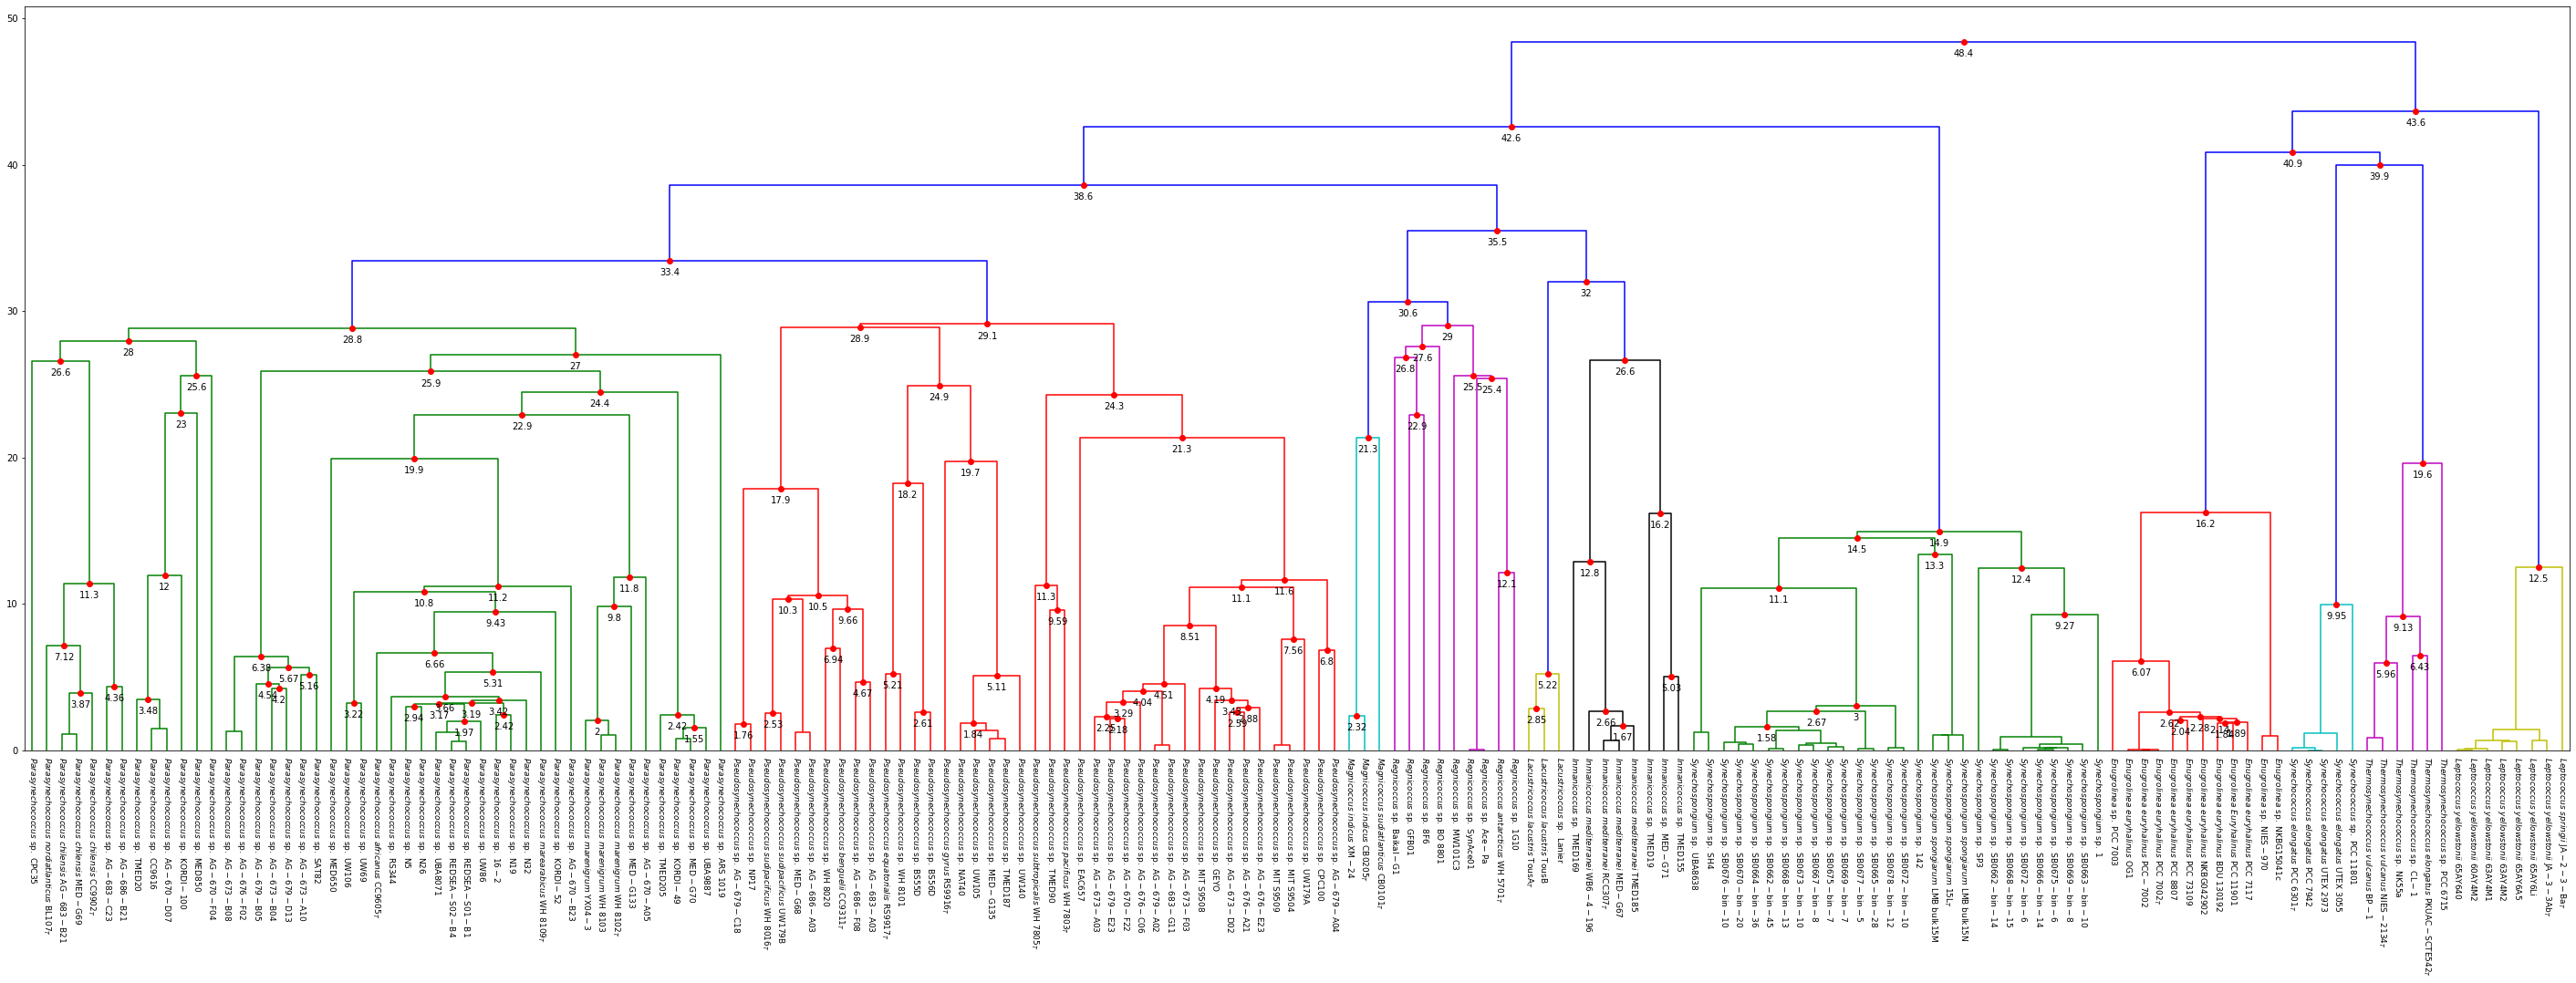

In [154]:
def augmented_dendrogram(*args, **kwargs):

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        for i, d in zip(ddata['icoord'], ddata['dcoord']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > 1.5:
                plt.plot(x, y, 'ro')
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -8),
                         textcoords='offset points',
                         va='top', ha='center')

    return ddata

fig = plt.figure(figsize=(50, 15))

dn = augmented_dendrogram(Z,
                          labels = table.columns,
                          leaf_rotation=-90,
                          color_threshold=30,
                          leaf_font_size=9,
                         )

plt.savefig(path.join(small_data, "aai/Figure_2_raw.png"), dpi=700, bbox_inches="tight")